In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [1]:
import os
from pathlib import Path
import pandas as pd
import pickle
import numpy as np

In [4]:
from collections import Counter, defaultdict

df_file = Path('data/selected_triplets.csv')
fixed_df_file = Path('selected_triplets_fixed.csv')
lengths = []
lengths_dict = defaultdict(list)
lines = []
with open(df_file, 'r') as file:
    for i, line in enumerate(file.readlines()):
        if i == 0 or len(line.split(',')) == 9:
            lines.append(line)
        lengths.append(len(line.split(',')))
        lengths_dict[len(line.split(','))].append((i, line))

with open(fixed_df_file, 'w') as file:
    file.writelines(lines)

In [5]:
df = pd.read_csv(fixed_df_file)
df['file_id'] = df.video_file.map(lambda p: int(os.path.split(p)[-1][:4]))
df = df[df.file_id == 37]
df.selected.value_counts()

0    3703
1    1599
2    1511
Name: selected, dtype: int64

In [6]:
import numpy as np
import torch
from torch import utils
import pandas as pd
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torch import nn 
from torch.nn import functional as F
import pytorch_lightning as pl
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from scipy import signal as sig
import os
from pathlib import Path
import re
from torch.utils import data
import random
import pandas as pd
import pickle
import numpy as np
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, confusion_matrix, accuracy_score

import cv2 as cv
from landmarks_video import LandmarksVideo
from triplets_gui import Animation, ClipsDisplay, VerificationApp
import landmarks_video
import triplets_gui

In [11]:
from deep_cluster.simple_autoencoder import Autoencoder, PLAutoencoder
from deep_cluster import dataloader
seqlen = 60
data_root = Path('/home/orel/Storage/Data/K7')
landmark_files = list(data_root.glob('2020-*/Down/*DeepCut*.h5'))
to_drop = ['head', 'forepawR2', 'forePawL2', 'chest1', 'chest2', 'belly1', 'belly2', 'hindpawR2', 
           'hindpawR3', 'hindpawL2', 'hindpawL3', 'tail1', 'tail2','tail3']
dm = dataloader.LandmarksDataModule(landmark_files, step=1, seqlen=seqlen, to_drop=None)
dm.prepare_data()
n_parts = len(dm.data_frames[0].columns.levels[0])
# model = PLAutoencoder([], n_neurons=[2*n_parts*seqlen, 1024, 512, 30], lr=5e-4, patience=20)
# model.load_state_dict(torch.load('../models/04_27_1/model.pt'))

In [120]:
def segment_confidence(segment_df):
    confidence = np.prod(segment_df.xs('likelihood', level=1, axis=1, drop_level=True) > 0.95, axis=1)
    return confidence.mean()

def segment_energy(segment_df):
    data = segment_df.drop('likelihood', level=1, axis=1).values.astype(np.float32)
    ff, Pxx = sig.periodogram(data.T, fs=120)
    energy = Pxx[:,:10].mean()
    return energy

def filter_segment(segment_df):
    return filter_by_likelihood(segment_df) and filter_by_energy(segment_df)

df = dm.all_df.iloc[:200000]
seqlen, step = 60, 20
energies, confidences = [], []
# filtered_by_energy, filtered_by_likelihood = [], []
for start in range(0, len(df), step):
    segment_df = df.iloc[start: start + seqlen]
    segment_df = segment_df.drop(tail_parts + shoulder_parts + ['nose'], axis=1, level=0)
    energies.append(segment_energy(segment_df))
    confidences.append(segment_confidence(segment_df))
#     filtered.append(filter_segment(segment_df))

energies, confidences = np.array(energies), np.array(confidences)

filtered_by_energy, filtered_by_likelihood = energies > 1e0, confidences > 0.95
filtered = np.logical_and(filtered_by_energy, filtered_by_likelihood)
filtered.mean()

0.0551

In [123]:
(confidences > 0.95).mean()

0.7985

In [119]:
(energies > 2e0).mean()

0.0851

In [125]:
(energies > 2e0).mean()

0.0967

In [118]:
np.logical_and(energies > 2e0, confidences > 0.9).mean()

0.0335

In [121]:
np.logical_and(energies > 2e0, confidences > 0.9).mean()

0.0402

In [102]:
(confidences > 0.95).mean()

0.6246445026763204

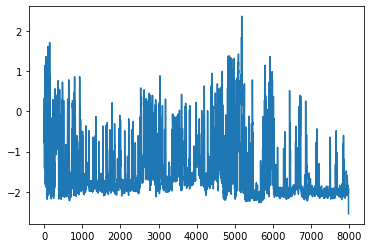

In [128]:
# energies_copy = energies.copy()
plt.plot(np.log10(energies[confidences > 0.95]))

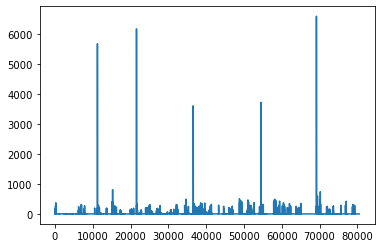

In [98]:
plt.plot(energies)
# plt.plot(confidences*1000)

In [ ]:
filtered_by_energy = map(filter_by_energy, [for start in range(0, len(df), step)])

1

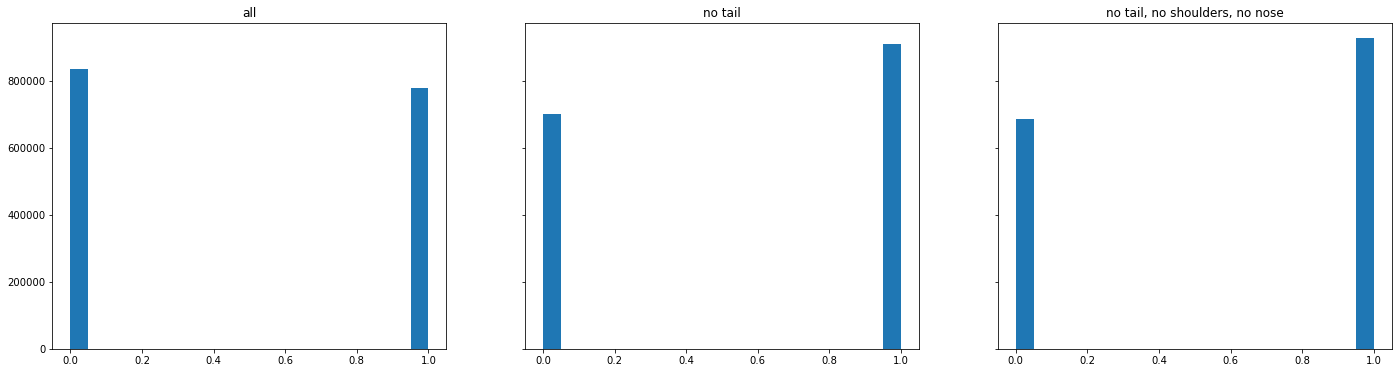

In [83]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 6), sharey=True)
threshold = 0.99
signal = np.prod(dm.all_df.xs('likelihood', axis=1, level=1), axis=1) < threshold
convolved = np.clip(1 - sig.convolve(signal, np.ones(60)), a_min=0, a_max=1)
axes[0].hist(convolved, bins=20)
signal = np.prod(dm.all_df.drop(labels=tail_parts, axis=1, level=0).xs('likelihood', axis=1, level=1), axis=1) < threshold
convolved = np.clip(1 - sig.convolve(signal, np.ones(60)), a_min=0, a_max=1)
axes[1].hist(convolved, bins=20)
signal = np.prod(dm.all_df.drop(labels=tail_parts + shoulder_parts + ['nose'], axis=1, level=0).xs('likelihood', axis=1, level=1), axis=1) < threshold
convolved = np.clip(1 - sig.convolve(signal, np.ones(60)), a_min=0, a_max=1)
axes[2].hist(convolved, bins=20)
axes[0].set_title('all')
axes[1].set_title('no tail')
axes[2].set_title('no tail, no shoulders, no nose')
1

In [9]:
landmarks_file_dir = Path(df.video_file.iloc[0]).parent
landmarks_file = next(landmarks_file_dir.glob('0037*.h5'))
landmarks_df = dataloader.read_df(landmarks_file)
landmarks_df = dataloader.drop_parts(landmarks_df, parts=['tail2'])
raw_landmarks_df = landmarks_df
landmarks_df = dataloader.process_df(landmarks_df)
processed_landmarks_df = landmarks_df.copy()
landmarks_df = dataloader.standardize_df(landmarks_df)
std_landmarks_df = landmarks_df.copy()
landmarks_df = dataloader.normalize_df(landmarks_df, means=dm.all_df.mean(), stds=dm.all_df.std())

In [10]:
landmarks_dataset = dataloader.SequenceDataset(landmarks_df.drop(axis=1, columns='likelihood', level=1), seqlen=60, step=1)
raw_landmarks_dataset = dataloader.SequenceDataset(raw_landmarks_df.drop(axis=1, columns='likelihood', level=1), seqlen=60, step=1)
X_encoded = model.model.encode(landmarks_dataset)

In [11]:
def get_segment_enc(X_encoded, start, end):
    mid = (start + end) // 2
#     return X_encoded[mid - seqlen//2]
    return X_encoded[start: end - seqlen].mean(axis=0)

def decode_segment_string(seg_string):
    start, end = seg_string[1:-1].split(',')
    return int(start), int(end)

def get_enc_from_string(seg_string):
    start, end = decode_segment_string(seg_string)
    return get_segment_enc(X_encoded, start, end)

def get_landmarks_from_string(seg_string):
    start, end = decode_segment_string(seg_string)
    return raw_landmarks_dataset.get_slice(start, end).reshape(-1)

In [12]:
# df.anchor.map(lambda o: get_segment_enc(X_encoded_dict['0015'], o))
for sample in ['anchor', 'sample1', 'sample2']:
    df[f'{sample}_enc'] = df[sample].map(lambda seg: get_enc_from_string(seg))
#     df[f'{sample}_input'] = df[sample].map(lambda seg: get_landmarks_from_string(seg))
df

<ipython-input-11-877c062d16e2>:4: RuntimeWarning: Mean of empty slice.
  return X_encoded[start: end - seqlen].mean(axis=0)
/home/shuki/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


,Unnamed: 0,video_file,anchor,sample1,sample2,selected,file_id,anchor_enc,sample1_enc,sample2_enc
3473,0,/home/orel/Storage/Data/K7/2020-08-04/Down/003...,"(1749, 1869)","(94819, 94939)","(182513, 182633)",0,37,"[-0.9704301, 1.2558113, -5.0032506, -1.7174952...","[0.89957833, -2.7230575, 6.5503836, -0.6836663...","[0.82959247, -6.897855, -5.027199, -0.6192924,..."
3474,0,/home/orel/Storage/Data/K7/2020-08-04/Down/003...,"(12992, 13112)","(14843, 14963)","(5587, 5707)",2,37,"[-0.2165635, 3.2434778, 4.009452, -0.3820403, ...","[-2.7036204, 11.176574, 10.003984, -2.9230478,...","[-3.103539, -7.409537, -4.8881507, 3.038812, -..."
3475,1,/home/orel/Storage/Data/K7/2020-08-04/Down/003...,"(125154, 125274)","(128141, 128261)","(122715, 122835)",0,37,"[-0.025234371, 5.944568, 9.34887, -0.110932596...","[-3.6310153, 14.089666, 2.4744678, -1.5533861,...","[-2.6045277, -14.720098, 4.3289056, 3.4913583,..."
3476,2,/home/orel/Storage/Data/K7/2020-08-04/Down/003...,"(182635, 182755)","(120801, 120921)","(81204, 81324)",1,37,"[2.3163953, -9.247509, -3.7398667, 0.47117674,...","[1.7604295, 6.2846894, -5.340807, 4.651999, -2...","[-1.1244495, 7.8854685, -5.0912633, -0.7388590..."
3477,3,/home/orel/Storage/Data/K7/2020-08-04/Down/003...,"(186386, 186506)","(22906, 23026)","(132130, 132250)",0,37,"[7.5310264, -2.5652444, 1.3911864, -0.0357512,...","[-1.7250286, 8.943391, -1.8531983, 0.4539074, ...","[0.7907474, 14.509521, 0.48699933, -2.703814, ..."
...,...,...,...,...,...,...,...,...,...,...
10276,0,/home/orel/Storage/Data/K7/2020-08-04/Down/003...,"(139781, 139841)","(150149, 150209)","(61317, 61377)",0,37,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
10277,0,/home/orel/Storage/Data/K7/2020-08-04/Down/003...,"(151503, 151563)","(84838, 84898)","(7746, 7806)",0,37,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
10278,0,/home/orel/Storage/Data/K7/2020-08-04/Down/003...,"(72593, 72653)","(90, 150)","(31805, 31865)",0,37,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
10279,0,/home/orel/Storage/Data/K7/2020-08-04/Down/003...,"(34893, 34953)","(151042, 151102)","(198820, 198880)",0,37,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


<AxesSubplot:>

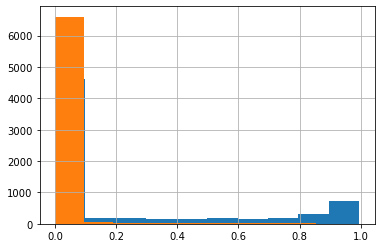

In [14]:
def find_likelihood(segment):
    start, end = decode_segment_string(segment)
#     parts = raw_landmarks_df.columns.levels[0]
    likelihood_df = raw_landmarks_df.loc[start:end].drop(axis=1, level=1, labels=['x', 'y'])
    likelihood_df.columns = likelihood_df.columns.levels[0]
    likelihood = np.prod(likelihood_df.values, axis=1)
    return np.prod(likelihood)

for sample in ['anchor', 'sample1', 'sample2']:
    df[f'{sample}_likelihood'] = df[sample].map(lambda seg: find_likelihood(seg))

df.anchor_likelihood.hist()
df['likelihood'] = df.anchor_likelihood * df.sample1_likelihood * df.sample2_likelihood
df.likelihood.hist()

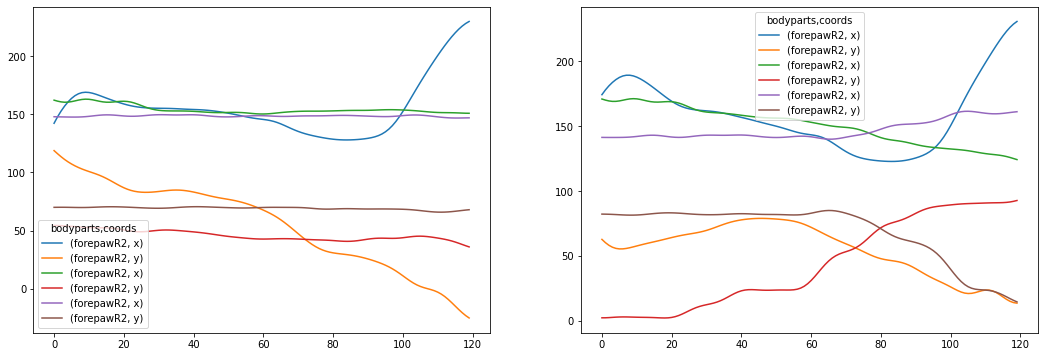

In [64]:
axis = plt.subplot(1,2,1)
idx = 8582
for  sample in ['anchor', 'sample1', 'sample2']:
    start, end = decode_segment_string(df.loc[idx][sample])
    sub_df = processed_landmarks_df.drop(['likelihood'], axis=1, level=1).iloc[start: end]
    sub_df = dataloader.standardize_df(sub_df, lock_theta=True)
    sub_df = sub_df[['forepawR2']]
#     sub_df = sub_df - sub_df.mean()
    sub_df.plot(figsize=(12, 6), ax=axis, use_index=False)

axis = plt.subplot(1,2,2)
for  sample in ['anchor', 'sample1', 'sample2']:
    start, end = decode_segment_string(df.loc[idx][sample])
    sub_df = processed_landmarks_df.drop(['likelihood'], axis=1, level=1).iloc[start: end]
    sub_df = dataloader.standardize_df(sub_df, lock_theta=False)
    sub_df = sub_df[['forepawR2']]
#     sub_df = sub_df - sub_df.mean()
    sub_df.plot(figsize=(18, 6), ax=axis, use_index=False)

In [13]:
import tkinter as tk
idx = 8582
clips = [decode_segment_string(df.loc[idx][sample]) for sample in ['anchor', 'sample1', 'sample2']]
clips = [video_unsmoothed[clip[0]:clip[1]:2] for clip in clips]
root = tk.Tk()
display = ClipsDisplay(root, clips=clips)
root.mainloop()

NameError: name 'video_unsmoothed' is not defined

In [12]:
import cv2 as cv
from landmarks_video import LandmarksVideo
from triplets_gui import Animation, ClipsDisplay, VerificationApp
import landmarks_video
video = LandmarksVideo(landmarks_df.attrs['file'].parent)
# video_unsmoothed = landmarks_video.LandmarksVideo(landmarks_df.attrs['file'].parent)

1

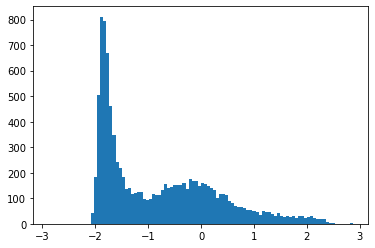

In [13]:
# def filter(segment_df):
#     data = segment_df.values.astype(np.float32)
#     ff, Pxx = sig.periodogram(data.T, fs=segment_df.attrs['fps'])
#     energy = Pxx.mean()
#     return energy > min_energy


def filter_df(segment_df):
    confidence = np.prod(segment_df.xs('likelihood', level=1, axis=1, drop_level=True) > 0.95, axis=1)
    return confidence.mean()

def filter_by_energy(segment_df):
    data = segment_df.drop('likelihood', level=1, axis=1).values.astype(np.float32)
    ff, Pxx = sig.periodogram(data.T, fs=segment_df.attrs['fps'])
    energy = Pxx[:,:10].mean()
    return energy
    
energies = []
filtered = []
for start in range(0, len(video.landmarks.df), 20):
    segment_df = video.landmarks.df.loc[start: start+60]
    segment_df = segment_df.drop('tail2', axis=1, level=0)
    energies.append(filter_by_energy(segment_df))
    filtered.append(filter_df(segment_df))
    
filtered = np.array(filtered)
energies = np.array(energies)
plt.hist(np.log10(np.array(energies)), bins=100)
1

In [17]:
idxs = np.where(np.logical_and(filtered >= 0.7, energies > 1e1))[0]
idx = np.random.choice(idxs)
segment_df = video.landmarks.df.loc[idx*20: idx*20 + 60]
energies[idx], filter_df(segment_df)
len(idxs)

369

In [21]:
os.listdir()

['wandb',
 'selected_triplets_fixed.csv',
 'triplets_model.py',
 '.ipynb_checkpoints',
 'mprofile_20210324111752.dat',
 'plots.pdf',
 'show_triplets.ipynb',
 '__init__.py',
 'landmarks_video.py',
 '__pycache__',
 'sample_triplets.py',
 'wc',
 'triplets_gui.py',
 '.idea',
 'Untitled.ipynb',
 'triplets_TSNE.ipynb',
 'data']

In [24]:
import tkinter as tk
import triplets_gui
from triplets_gui import App
# idx = np.random.choice(idxs)
# clip = video[idx*20: idx*20 + 60]
root = tk.Tk()
gui = App(root, video, save_file='data/strong_triplets.csv')
# Animation(root, clip)
root.mainloop()

[autoreload of triplets_gui failed: Traceback (most recent call last):
  File "/home/shuki/anaconda3/envs/torch/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/shuki/anaconda3/envs/torch/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/shuki/anaconda3/envs/torch/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/shuki/anaconda3/envs/torch/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/shuki/anaconda3/envs/torch/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/shuki/anaconda3/envs/torch/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 266, in 

start load clips
finish load clips
start load clips
finish load clips
[INFO] caught a RuntimeError
[INFO] caught a RuntimeError
start load clips
finish load clips
[INFO] caught a RuntimeError
[INFO] caught a RuntimeError
start load clips
finish load clips
[INFO] caught a RuntimeError
[INFO] caught a RuntimeError
[INFO] caught a RuntimeError
start load clips
finish load clips
[INFO] caught a RuntimeError
[INFO] caught a RuntimeError
start load clips
finish load clips
[INFO] caught a RuntimeError
start load clips
finish load clips
[INFO] caught a RuntimeError
[INFO] caught a RuntimeError
start load clips
finish load clips
[INFO] caught a RuntimeError
[INFO] caught a RuntimeError
start load clips
finish load clips
[INFO] caught a RuntimeError
[INFO] caught a RuntimeError
start load clips
finish load clips
[INFO] caught a RuntimeError
[INFO] caught a RuntimeError
start load clips
finish load clips
[INFO] caught a RuntimeError
[INFO] caught a RuntimeError
start load clips
finish load clips


Exception in thread Thread-174:
Traceback (most recent call last):
  File "/home/shuki/anaconda3/envs/torch/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/shuki/anaconda3/envs/torch/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shuki/Projects/deep_cluster/deep_cluster/triplets/triplets_gui.py", line 101, in animation
    self.create_image(0, 0, image=self.images[i], anchor='nw')
AttributeError: 'Animation' object has no attribute 'images'


start load clips
finish load clips
start load clips
finish load clips
start load clips
finish load clips
[INFO] caught a RuntimeError
start load clips
finish load clips
[INFO] caught a RuntimeError
[INFO] caught a RuntimeError
start load clips
finish load clips
[INFO] caught a RuntimeError
start load clips
finish load clips
[INFO] caught a RuntimeError
[INFO] caught a RuntimeError
quitting


Exception in thread Thread-191:
Traceback (most recent call last):
  File "/home/shuki/anaconda3/envs/torch/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/shuki/anaconda3/envs/torch/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shuki/Projects/deep_cluster/deep_cluster/triplets/triplets_gui.py", line 101, in animation
    self.create_image(0, 0, image=self.images[i], anchor='nw')
  File "/home/shuki/anaconda3/envs/torch/lib/python3.8/tkinter/__init__.py", line 2785, in create_image
    return self._create('image', args, kw)
  File "/home/shuki/anaconda3/envs/torch/lib/python3.8/tkinter/__init__.py", line 2771, in _create
    return self.tk.getint(self.tk.call(
RuntimeError: main thread is not in main loop


In [16]:
import tkinter as tk
root = tk.Tk()
df1 = df[df.likelihood > 0.5]
df1 = df1[df1.selected != 0]

VerificationApp(root, video=video, df=df1, to_save=False)
root.mainloop()

start load clips
finish load clips
Filename: /home/shuki/Projects/deep_cluster/deep_cluster/triplets/triplets_gui.py

Line #    Mem usage    Increment  Occurences   Line Contents
   114   6312.8 MiB   6312.8 MiB           1       @profile
   115                                             def __init__(self, root, clips, fps=30, *args, **kwargs):
   116   6312.8 MiB      0.0 MiB           1           tk.Frame.__init__(self, root, *args, **kwargs)
   117   6312.8 MiB      0.0 MiB           1           self.window = tk.Frame(self)
   118   6312.8 MiB      0.0 MiB           6           n_frames = int(np.mean([len(clip) for clip in clips]))
   119   6312.8 MiB      0.1 MiB           1           self.anchor_anim = Animation(self, clips[0], fps=fps, n_frames=n_frames, rescale=1.5)#, width=100, height=240)
   120   6312.8 MiB      0.0 MiB           1           self.anchor_anim.pack(side=tk.LEFT)
   121   6312.8 MiB      0.0 MiB           1           pos_frame = tk.Frame(self.window)
   122   6

Exception in thread Thread-74:
Traceback (most recent call last):
  File "/home/shuki/anaconda3/envs/torch/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/shuki/anaconda3/envs/torch/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shuki/Projects/deep_cluster/deep_cluster/triplets/triplets_gui.py", line 101, in animation
    self.create_image(0, 0, image=self.images[i], anchor='nw')
AttributeError: 'Animation' object has no attribute 'images'


Filename: /home/shuki/Projects/deep_cluster/deep_cluster/triplets/triplets_gui.py

Line #    Mem usage    Increment  Occurences   Line Contents
   114   6067.4 MiB   6067.4 MiB           1       @profile
   115                                             def __init__(self, root, clips, fps=30, *args, **kwargs):
   116   6067.4 MiB      0.0 MiB           1           tk.Frame.__init__(self, root, *args, **kwargs)
   117   6067.4 MiB      0.0 MiB           1           self.window = tk.Frame(self)
   118   6067.4 MiB      0.0 MiB           6           n_frames = int(np.mean([len(clip) for clip in clips]))
   119   6067.4 MiB      0.0 MiB           1           self.anchor_anim = Animation(self, clips[0], fps=fps, n_frames=n_frames, rescale=1.5)#, width=100, height=240)
   120   6067.4 MiB      0.0 MiB           1           self.anchor_anim.pack(side=tk.LEFT)
   121   6067.4 MiB      0.0 MiB           1           pos_frame = tk.Frame(self.window)
   122   6067.4 MiB      0.0 MiB           1 

Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/shuki/anaconda3/envs/torch/lib/python3.8/tkinter/__init__.py", line 1883, in __call__
    return self.func(*args)
  File "/home/shuki/Projects/deep_cluster/deep_cluster/triplets/triplets_gui.py", line 319, in next
    self.reload_display()
  File "/home/shuki/Projects/deep_cluster/deep_cluster/triplets/triplets_gui.py", line 348, in reload_display
    self.load_clips()
  File "/home/shuki/Projects/deep_cluster/deep_cluster/triplets/triplets_gui.py", line 362, in load_clips
    self.new_triplet()
  File "/home/shuki/Projects/deep_cluster/deep_cluster/triplets/triplets_gui.py", line 323, in new_triplet
    row = self.df.iloc[self.i]
  File "/home/shuki/anaconda3/envs/torch/lib/python3.8/site-packages/pandas/core/indexing.py", line 879, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)
  File "/home/shuki/anaconda3/envs/torch/lib/python3.8/site-packages/pandas/core/indexing.py", line 1496,

In [1]:
1

1

In [60]:
df['d1'] = (df['anchor_enc'] - df['sample1_enc']).map(np.linalg.norm)
df['d2'] = (df['anchor_enc'] - df['sample2_enc']).map(np.linalg.norm)
df['d3'] = (df['sample1_enc'] - df['sample2_enc']).map(np.linalg.norm)
df['pred_selected'] = (df['d1'] <= df['d2']).map(lambda b: 1 if b else 2)
# df['pred_selected1'] = (df['d1'] + 20 <= df['d2'])#.map(lambda b: '1' if b else '2')
# df['pred_selected2'] = (df['d2']  + 20 <= df['d1'])#.map(lambda b: '1' if b else '2')
df['pred_correct'] = (df.selected == df.pred_selected)
df.drop(labels=['d1', 'd2', 'd3'], axis=1)
df.describe()
df[(df.selected != 0)]['pred_correct'].value_counts()

False    1557
True     1553
Name: pred_correct, dtype: int64

In [11]:
df.describe()

,Unnamed: 0,selected,file_id,d1,d2,d3,pred_selected
count,6803.000000,6803.000000,6803.0,6803.000000,6803.000000,6803.000000,6803.000000
mean,9.278995,0.679259,37.0,9.579326,9.544519,9.623938,1.499339
std,5.827604,0.813744,0.0,6.778808,6.193630,6.485636,0.500036
min,0.000000,0.000000,37.0,0.053336,0.792905,0.321422,1.000000
25%,4.000000,0.000000,37.0,6.508548,6.526455,6.522430,1.000000
50%,9.000000,0.000000,37.0,8.744882,8.753704,8.825658,1.000000
75%,14.000000,1.000000,37.0,11.368757,11.496097,11.610571,2.000000
max,25.000000,2.000000,37.0,102.957642,102.354759,102.427528,2.000000


In [81]:
df['d1'] = (df['anchor_input'] - df['sample1_input']).map(np.linalg.norm)
df['d2'] = (df['anchor_input'] - df['sample2_input']).map(np.linalg.norm)
df['d3'] = (df['sample1_input'] - df['sample2_input']).map(np.linalg.norm)
df['pred_selected'] = (df['d1'] <= df['d2']).map(lambda b: 1 if b else 2)
df['pred_selected1'] = (df['d1'] + 20 <= df['d2'])#.map(lambda b: '1' if b else '2')
df['pred_selected2'] = (df['d2']  + 20 <= df['d1'])#.map(lambda b: '1' if b else '2')
df['pred_correct'] = (df.selected == df.pred_selected)
df[df.selected != 0]['pred_correct'].value_counts()

True     1569
False    1541
Name: pred_correct, dtype: int64